In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
!pip install openpyxl
import os
import requests
import pandas as pd
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib.colors import LogNorm, Normalize
from matplotlib.gridspec import GridSpec
import scipy.stats as stats
!pip install libpysal
!pip install esda
!pip install pysal
from esda.getisord import G_Local
from libpysal.weights import Queen
from matplotlib.colors import SymLogNorm
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize
from scipy.stats import ttest_ind
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import ListedColormap, BoundaryNorm
from Aggregate_Risk_Weights import *

# Specifications

In [2]:
optimal_cluster = 'st_cluster_3_5_7'
save = False

# Policies

In [3]:
# Load aggregated sum policies by state
policies = pd.read_csv("../Local_Data/NFIP_Data/policy_total_county_averages.csv")

# Filter out rows with missing or blank values in the relevant columns
policies = policies.dropna(subset=['countyCode', 'policyCost_mean', 'totalInsurancePremiumOfThePolicy_mean'])
policies['countyCode'] = policies['countyCode'].astype(int).astype(str)
policies['countyCode'] = policies['countyCode'].apply(lambda x: str(x).zfill(5))
policies['oldest_year'] = policies['oldest_year'] -1 
policies['most_recent_year'] = policies['most_recent_year'] -1 

# Risk Rating 2.0 Policies

In [4]:
risk_policies = pd.read_excel('../Local_Data/NFIP_Data/nfip_policy-information-by-state_20240531.xlsx', sheet_name='PIF')

risk_policies['County'] = risk_policies['County'].str.strip()
risk_policies['State'] = risk_policies['State'].str.strip()

aggregated_risk_policies = risk_policies.groupby(['County', 'State']).agg({
    'Policies in Force': 'sum',
    'Total Coverage': 'sum',
    'Total Written Premium + FPF': 'sum',
    'Total Annual Payment': 'sum'
}).reset_index()

In [5]:
# Read the file line by line
with open('../Local_Data/fips_codes.txt', 'r') as file:
    lines = file.readlines()

# Identify where state-level data starts and ends
state_section_start = 0
county_section_start = 0

for i, line in enumerate(lines):
    if "state-level" in line.lower():
        state_section_start = i + 2  # State data starts after the "state-level" heading
    if "county-level" in line.lower():
        county_section_start = i + 2  # County data starts after the "county-level" heading
        break

# Manually create the dictionary mapping state FIPS codes to state names
state_fips_dict = {
    "01": "ALABAMA",
    "02": "ALASKA",
    "04": "ARIZONA",
    "05": "ARKANSAS",
    "06": "CALIFORNIA",
    "08": "COLORADO",
    "09": "CONNECTICUT",
    "10": "DELAWARE",
    "11": "DISTRICT OF COLUMBIA",
    "12": "FLORIDA",
    "13": "GEORGIA",
    "15": "HAWAII",
    "16": "IDAHO",
    "17": "ILLINOIS",
    "18": "INDIANA",
    "19": "IOWA",
    "20": "KANSAS",
    "21": "KENTUCKY",
    "22": "LOUISIANA",
    "23": "MAINE",
    "24": "MARYLAND",
    "25": "MASSACHUSETTS",
    "26": "MICHIGAN",
    "27": "MINNESOTA",
    "28": "MISSISSIPPI",
    "29": "MISSOURI",
    "30": "MONTANA",
    "31": "NEBRASKA",
    "32": "NEVADA",
    "33": "NEW HAMPSHIRE",
    "34": "NEW JERSEY",
    "35": "NEW MEXICO",
    "36": "NEW YORK",
    "37": "NORTH CAROLINA",
    "38": "NORTH DAKOTA",
    "39": "OHIO",
    "40": "OKLAHOMA",
    "41": "OREGON",
    "42": "PENNSYLVANIA",
    "44": "RHODE ISLAND",
    "45": "SOUTH CAROLINA",
    "46": "SOUTH DAKOTA",
    "47": "TENNESSEE",
    "48": "TEXAS",
    "49": "UTAH",
    "50": "VERMONT",
    "51": "VIRGINIA",
    "53": "WASHINGTON",
    "54": "WEST VIRGINIA",
    "55": "WISCONSIN",
    "56": "WYOMING"
}

# Convert the dictionary to a DataFrame for easy merging
state_df = pd.DataFrame(list(state_fips_dict.items()), columns=['State FIPS', 'State Name'])

# Split the data into sections
state_section_start = 0
county_section_start = 0

for i, line in enumerate(lines):
    if "state-level" in line.lower():
        state_section_start = i + 2  # Skip the header lines
    if "county-level" in line.lower():
        county_section_start = i + 2  # Skip the header lines
        break

state_lines = lines[state_section_start:county_section_start-2]  # State data lines
county_lines = lines[county_section_start:]  # County data line

# Parse county data
county_fips = []
county_name = []

for line in county_lines:
    line = line.strip()
    if len(line) > 12 and line[:5].isdigit():
        county_fips_code = line[:5].strip()
        county_fips_name = line[12:].strip()
        county_fips.append(county_fips_code)
        county_name.append(county_fips_name)

county_df = pd.DataFrame({
    'countyCode': county_fips,
    'County Name': county_name
})

county_df['State FIPS'] = county_df['countyCode'].str[:2]  # Extract state FIPS from the countyCode

# Merge
fips_df = county_df.merge(state_df, on='State FIPS')
fips_df['County Name'] = fips_df['County Name'].str.upper()

In [6]:
# Ensure that County and State names are fully capitalized in the aggregated_risk_policies DataFrame
aggregated_risk_policies['County'] = aggregated_risk_policies['County'].str.upper()
aggregated_risk_policies['State'] = aggregated_risk_policies['State'].str.upper()

# Merge the DataFrames
aggregated_risk_policies = aggregated_risk_policies.merge(fips_df, left_on=['County', 'State'], right_on=['County Name', 'State Name'], how='left')

# Drop unnecessary columns (optional)
aggregated_risk_policies = aggregated_risk_policies.drop(columns=['County Name', 'State Name'])

# Load Shapefile Data

In [7]:
# Load the shapefile for US counties
shapefile_path = '../Local_Data/Geospatial/tl_2019_us_county.shp'
gdf_counties = gpd.read_file(shapefile_path)

# Load the shapefile for US states
state_shapefile_path = '../Local_Data/Geospatial/cb_2018_us_state_20m.shp'
gdf_states = gpd.read_file(state_shapefile_path)

# Load Disaster Count

In [8]:
final_disasters_df = pd.read_csv("../2_Low_Return_Period/no_percentile_filter/final_filtered_disasters.csv")
final_disasters_df['fullFIPS'] = final_disasters_df['fullFIPS'].astype(int).astype(str)
final_disasters_df['fullFIPS'] = final_disasters_df['fullFIPS'].apply(lambda x: str(x).zfill(5))

# Read the two CSV files
owners_df = pd.read_csv("../2_Low_Return_Period/no_percentile_filter/final_filtered_aid_owners.csv")
renters_df = pd.read_csv("../2_Low_Return_Period/no_percentile_filter/final_filtered_aid_renters.csv")

# Concatenate and merge the dataframes
filtered_aid_df = pd.concat([owners_df, renters_df], ignore_index=True)
filtered_aid_df['fullFIPS'] = filtered_aid_df['fullFIPS'].astype(int).astype(str)
filtered_aid_df['fullFIPS'] = filtered_aid_df['fullFIPS'].apply(lambda x: str(x).zfill(5))
filtered_aid_df = filtered_aid_df.groupby(["disasterNumber","fullFIPS"]).agg({'approvedForFemaAssistance': 'sum' }).reset_index()
final_disasters_df = final_disasters_df.merge(filtered_aid_df[["disasterNumber","fullFIPS",'approvedForFemaAssistance']], how="left", on=["disasterNumber","fullFIPS"])

# Replace NaNs with 0 and ensure all values are non-negative integers
final_disasters_df['approvedForFemaAssistance'] = pd.to_numeric(
    final_disasters_df['approvedForFemaAssistance'], errors='coerce'
).fillna(0).clip(lower=0).astype(int)

# Ensure the column is an integer (it should represent the number of repetitions)
final_disasters_df = final_disasters_df.loc[final_disasters_df.index.repeat(final_disasters_df['approvedForFemaAssistance'])]

# Ensure fullFIPS has leading zeros (5 characters)
final_disasters_df['fullFIPS'] = final_disasters_df['fullFIPS'].astype(int).astype(str).str.zfill(5)

count_by_fips_df = final_disasters_df.groupby('fullFIPS').size().reset_index(name='disasterCount')

# Merge the aggregated data with the shapefile
gdf_counties = gdf_counties.merge(count_by_fips_df, left_on='GEOID', right_on='fullFIPS', how='left', suffixes=('', '_drop'))

# Drop the duplicate 'countyCode_drop' column from the merge
gdf_counties.drop(columns=['fullFIPS_drop'], inplace=True, errors='ignore')

# Replace missing values in 'meanLoss' with 0
gdf_counties['disasterCount'] = gdf_counties['disasterCount'].fillna(0)

# Load Multiple Loss Properties

In [9]:
multi_loss = pd.read_csv('../Local_Data/NFIP_Data/NfipMultipleLossProperties.csv')

# Ensure the countyCode is a string with leading zeros if needed
multi_loss = multi_loss.dropna(subset=['fipsCountyCode'])
multi_loss['fipsCountyCode'] = multi_loss['fipsCountyCode'].astype(int).astype(str)
multi_loss['fipsCountyCode'] = multi_loss['fipsCountyCode'].apply(lambda x: str(x).zfill(5))

county_multi_loss = multi_loss.groupby("fipsCountyCode").aggregate({
    'nfipRl':'sum',
    'nfipSrl':'sum',
    'fmaRl':'sum',
    'fmaSrl':'sum',
    'totalLosses':'sum',
    'primaryResidenceIndicator':'sum',
    'mitigatedIndicator':'sum',
    'insuredIndicator':'sum'}).reset_index()
county_multi_loss['Rl'] = county_multi_loss['nfipRl']+county_multi_loss['fmaRl']
county_multi_loss['Srl'] = county_multi_loss['nfipSrl']+county_multi_loss['fmaSrl']
county_multi_loss['totalMultiLossProp'] = county_multi_loss['Rl']+county_multi_loss['Srl']

# Merge the aggregated data with the shapefile
gdf_counties = gdf_counties.merge(county_multi_loss[['fipsCountyCode','totalMultiLossProp']], left_on='GEOID', right_on='fipsCountyCode', how='left')

# Load the shapefile for US states
state_shapefile_path = '../Local_Data/Geospatial/cb_2018_us_state_20m.shp'
gdf_states = gpd.read_file(state_shapefile_path)

# Replace missing values in 'meanLoss' with 0
gdf_counties['totalMultiLossProp'] = gdf_counties['totalMultiLossProp'].fillna(0)

# Load Clustered Claims

In [10]:
# Load claims data
claims = pd.read_csv("clustered_claims_final.csv", low_memory=False)

# 1) Coerce dtypes
num_cols = ["latitude", "longitude", "adjustedClaim"]
claims[num_cols] = claims[num_cols].apply(pd.to_numeric, errors="coerce")
claims["dateOfLoss"] = pd.to_datetime(claims["dateOfLoss"], errors="coerce")
claims['countyCode'] = claims['countyCode'].astype(int).astype(str)
claims['countyCode'] = claims['countyCode'].apply(lambda x: str(x).zfill(5))

## County Contributions

In [11]:
# Filter out rows with missing or blank values in the relevant columns
filtered_data = claims.dropna(subset=['countyCode', 'buildingDamageAmount', 'buildingPropertyValue', 'adjustedClaim', 'yearOfLoss'])
filtered_data['countyCode'] = filtered_data['countyCode'].astype(int).astype(str)
filtered_data['countyCode'] = filtered_data['countyCode'].apply(lambda x: str(x).zfill(5))
filtered_data['mitigatedClaim'] = filtered_data['elevatedBuildingIndicator'] | filtered_data['floodproofedIndicator']

# Aggregate the data by countyCode and yearOfLoss
aggregated_yearly_data = filtered_data.groupby(['countyCode', 'yearOfLoss']).agg({
    'adjustedClaim':'sum',
    'buildingDamageAmount': 'sum',
    'buildingPropertyValue': 'sum',
    'mitigatedClaim':'mean'
}).reset_index()

# Count the number of years available for each county and track min and max year
years_stats = aggregated_yearly_data.groupby('countyCode').agg({
    'yearOfLoss': ['count', 'min', 'max']
}).reset_index()

# Flatten the multi-level columns after aggregation
years_stats.columns = ['countyCode', 'years_averaged', 'min_yearOfLoss', 'max_yearOfLoss']

# Sum the yearly data across all years for each county
aggregated_county_data = aggregated_yearly_data.groupby('countyCode').agg({
    'adjustedClaim':'sum',
    'buildingDamageAmount': 'sum',
    'buildingPropertyValue': 'sum',
    'mitigatedClaim':'mean'
}).reset_index()

# Merge with the years_stats to keep track of the number of years averaged over, min, and max years
aggregated_county_data = pd.merge(aggregated_county_data, years_stats, on='countyCode')

# Merge the two DataFrames on 'countyCode'
merged_data = pd.merge(aggregated_county_data, policies, on='countyCode', how='inner', suffixes=('_claims', '_policies'))

# Calculate the minimum of the two min_yearOfLoss and the maximum of the two max_yearOfLoss
merged_data['min_yearOfLoss'] = merged_data[['min_yearOfLoss', 'oldest_year']].min(axis=1)
merged_data['max_yearOfLoss'] = merged_data[['max_yearOfLoss', 'most_recent_year']].max(axis=1)

# Calculate the total number of years (max - min + 1)
merged_data['total_years'] = merged_data['max_yearOfLoss'] - merged_data['min_yearOfLoss'] + 1

# Drop the original min/max columns if no longer needed
merged_data = merged_data.drop(columns=['min_yearOfLoss', 'oldest_year', 'max_yearOfLoss', 'most_recent_year'])

# Calculate the mean yearly value by dividing by the actual number of years present for each county
merged_data['mean_adjustedClaim'] = merged_data['adjustedClaim'] / merged_data['total_years']
merged_data['mean_buildingDamageAmount'] = merged_data['buildingDamageAmount'] / merged_data['total_years']
merged_data['mean_buildingPropertyValue'] = merged_data['buildingPropertyValue'] / merged_data['total_years']

# Reset index to keep the final structure
merged_data.reset_index(drop=True, inplace=True)

# Mean Loss
merged_data['meanLoss_hist'] = merged_data['totalInsurancePremiumOfThePolicy_mean']-merged_data['mean_adjustedClaim']

# Merge the two DataFrames on 'countyCode'
merged_data = pd.merge(merged_data, aggregated_risk_policies, on='countyCode', how='inner', suffixes=('_claims', '_policies'))

# Mean Loss
merged_data['meanLoss'] = merged_data['Total Written Premium + FPF']-merged_data['mean_adjustedClaim']

# Loss per HH Insured
merged_data['lossPerInsured'] = merged_data['meanLoss']/merged_data['Policies in Force']

# Merge the aggregated data with the shapefile
gdf_counties = gdf_counties.merge(merged_data, left_on='GEOID', right_on='countyCode', how='left')

In [12]:
# Replace missing values in 'meanLoss' with 0
gdf_counties['lossOnly'] = gdf_counties['meanLoss'].fillna(0)

# Set 'meanLoss' values that are greater than or equal to 0 to 0
gdf_counties.loc[gdf_counties['lossOnly'] >= 0, 'lossOnly'] = 0
gdf_counties['lossOnly']=gdf_counties['lossOnly']*-1

# Replace missing values in 'meanLoss' with 0
gdf_counties['lossOnly'] = gdf_counties['lossOnly'].fillna(0)

## Hyperclustered Claims

In [13]:
# Copy claims dataframe
claims_masked = claims.copy()

# Group by 'optimal_cluster' and sort by size
claims_masked = claims_masked[claims_masked[optimal_cluster] != -1]
grouped_clusters = (
    claims_masked.groupby(optimal_cluster)['adjustedClaim']
    .sum()
    .sort_values(ascending=False)
)

# Print the billion-dollar clusters
top_clusters = grouped_clusters[grouped_clusters > 1000000000]

# Compute the 99.9th percentile of cluster claim sizes
p999_value = np.percentile(grouped_clusters, 99.9)

# Select clusters whose claim size exceeds that percentile
top_clusters_2 = grouped_clusters[grouped_clusters > p999_value]

In [14]:
billion_dollar_claims = claims[claims[optimal_cluster].isin(top_clusters.index)].copy()

billion_dollar_claims['countyCode'] = billion_dollar_claims['countyCode'].astype(int).astype(str)
billion_dollar_claims['countyCode'] = billion_dollar_claims['countyCode'].apply(lambda x: str(x).zfill(5))

# Count the number of rows associated with each 'countyCode'
hyper_count = billion_dollar_claims.groupby('countyCode').size().reset_index(name='hyperCount')

# Merge the 'hyper_count' column with 'gdf_counties' on 'GEOID' using 'countyCode'
gdf_counties = gdf_counties.merge(hyper_count, left_on='GEOID', right_on='countyCode', how='left', suffixes=('', '_drop'))

# Drop the duplicate 'countyCode_drop' column from the merge
gdf_counties.drop(columns=['countyCode_drop'], inplace=True, errors='ignore')

# Drop the duplicate 'countUncluster_drop' column from the merge
gdf_counties.drop(columns=['countUncluster_drop'], inplace=True, errors='ignore')

# Replace NaN values with 0 (for counties with no data points)
gdf_counties['hyperCount'] = gdf_counties['hyperCount'].fillna(0)

## Unclustered Claims

In [15]:
# Filter claims to only include rows where optimal_cluster == -1
filtered_claims = claims[claims[optimal_cluster] == -1].copy()
filtered_claims['countyCode'] = filtered_claims['countyCode'].astype(int).astype(str)
filtered_claims['countyCode'] = filtered_claims['countyCode'].apply(lambda x: str(x).zfill(5))

# Group by 'countyCode' and count the number of datapoints
cluster_counts = filtered_claims.groupby('countyCode').size().reset_index(name='countUncluster')

# Merge the grouped counts with gdf_counties based on 'countyCode' and 'GEOID'
gdf_counties = gdf_counties.merge(cluster_counts, left_on='GEOID', right_on='countyCode', how='left', suffixes=('', '_drop'))

# Drop the duplicate 'countyCode_drop' column from the merge
gdf_counties.drop(columns=['countyCode_drop'], inplace=True, errors='ignore')

# Drop the duplicate 'countUncluster_drop' column from the merge
gdf_counties.drop(columns=['hyperCount_drop'], inplace=True, errors='ignore')

# Replace NaN values with 0 (for counties with no data points)
gdf_counties['countUncluster'] = gdf_counties['countUncluster'].fillna(0)

# Aggregate Weighting

In [16]:
# Inputs
metrics = ["lossOnly", "hyperCount", "disasterCount", "totalMultiLossProp", "countUncluster"]
risk_levels = ["lowest", "lower", "medium", "higher", "highest"]

pairwise_matrix = np.array([
    [1,   2,   3,   4,   5],
    [1/2, 1,   2,   3,   4],
    [1/3, 1/2, 1,   2,   3],
    [1/4, 1/3, 1/2, 1,   2],
    [1/5, 1/4, 1/3, 1/2, 1],
], dtype=float)

# Run the pipeline
result = return_weights(
    gdf_counties,
    metrics,
    pairwise_matrix,
    normalize=False,
    non_neg=True,
    log_for_entropy=True,             # set False for entropy on raw values
    standardize_for_composite=True,   # recommended
    num_bins=5,
    risk_cats=risk_levels
)

# Print weights
print("\n--- Weights ---")
for key, w in result['weights'].items():
    print(f"{key} weights:")
    if key == 'Thresholds':
        print(w)
    else:
        for metric, val in zip(metrics, w):
            print(f"   {metric}: {val:.4f}")


--- Weights ---
EW weights:
   lossOnly: 0.2000
   hyperCount: 0.2000
   disasterCount: 0.2000
   totalMultiLossProp: 0.2000
   countUncluster: 0.2000
SW weights:
   lossOnly: 0.4185
   hyperCount: 0.2625
   disasterCount: 0.1599
   totalMultiLossProp: 0.0973
   countUncluster: 0.0618
OW weights:
   lossOnly: 0.3353
   hyperCount: 0.4157
   disasterCount: 0.1066
   totalMultiLossProp: 0.1003
   countUncluster: 0.0422
CW weights:
   lossOnly: 1.4462
   hyperCount: 0.9951
   disasterCount: 0.5433
   totalMultiLossProp: 0.3456
   countUncluster: 0.2103
Thresholds weights:
[0.12246454 0.49745166 1.20689492 2.3151536 ]


# Plot 7

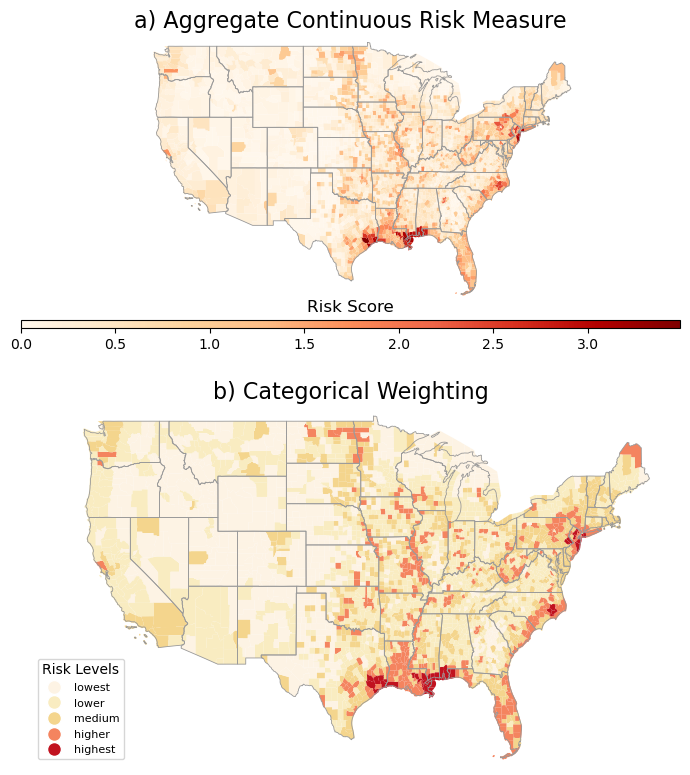

In [17]:
# Extract gdf
gdf_counties = result['gdf']

# Define extent and colormap
extent = [-130, -65, 24, 50]  # [min lon, max lon, min lat, max lat]
cmap = plt.cm.OrRd  # Continuous colormap for Risk Score

# Define discrete colormap for Risk Levels
colors = ["#fdf3e4", "#f9ecc1", "#f4d58d", "#f4845f",  "#c1121f"] # Example OrRd shades
discrete_cmap = mcolors.ListedColormap(colors)

# Create a figure with two stacked subplots
fig, axes = plt.subplots(2, 1, figsize=(7, 8))  # 2 rows, 1 column of subplots

# === Plot 1: Risk Score (Continuous) ===
ax1 = axes[0]
divider = make_axes_locatable(ax1)

# Plot the continuous risk score
gdf_counties.plot(column='Risk_Score', cmap=cmap, legend=False, ax=ax1, linewidth=0.1)
gdf_states.boundary.plot(ax=ax1, edgecolor='0.6', linewidth=0.6)

# Configure plot 1
ax1.set_title('a) Aggregate Continuous Risk Measure', fontsize=16)
ax1.set_xlim(extent[0], extent[1])
ax1.set_ylim(extent[2], extent[3])
ax1.axis('off')

# Add colorbar below the first plot
vmin = gdf_counties['Risk_Score'].min()
vmax = gdf_counties['Risk_Score'].max()
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

cax = divider.append_axes("bottom", size="3%", pad=0.2)  # Adjust size and padding
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(sm, cax=cax, orientation='horizontal')
cax.set_title('Risk Score')

# === Plot 2: Risk Levels (Categorical) ===
ax2 = axes[1]

# Ensure Risk_Category is numerical and mapped correctly
risk_mapping = {label: i + 1 for i, label in enumerate(risk_levels)}
gdf_counties["Risk_Category_Num"] = gdf_counties["Risk_Category"].map(risk_mapping)

# Plot discrete categorical risk levels
gdf_counties.plot(column="Risk_Category_Num", cmap=discrete_cmap, legend=False, ax=ax2, linewidth=0.1)
gdf_states.boundary.plot(ax=ax2, edgecolor="0.6", linewidth=0.6)

# Manually create legend for categorical risk levels
legend_labels = risk_levels
legend_colors = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) 
    for color in colors
]
ax2.legend(
    legend_colors, legend_labels, title="Risk Levels", loc="lower left", frameon=True, fontsize=8
)

# Configure plot 2
ax2.set_title("b) Categorical Weighting", fontsize=16)
ax2.set_xlim(extent[0], extent[1])
ax2.set_ylim(extent[2], extent[3])
ax2.axis("off")

# Adjust layout and display
plt.tight_layout()

if save:
    output_path = 'Plots/F6_Aggregate_Risk.png'
    plt.savefig(output_path, dpi=500, bbox_inches='tight')

plt.show()

In [18]:
exclude_states = {"02", "15", "72", "60", "66", "69", "78"}
gdf_counties = gdf_counties[~gdf_counties["STATEFP"].isin(exclude_states)].copy()

In [19]:
# Filter to rows with a non-null countyCode
filtered = gdf_counties[gdf_counties["countyCode"].notna() & (gdf_counties["countyCode"] != "")]

# Export only the desired columns
filtered[['countyCode', "lossOnly", "hyperCount", "disasterCount",
          "totalMultiLossProp", "countUncluster", 'Risk_Score', 'Risk_Category']] \
    .to_csv("County_Risk_Scores.csv", index=False)